In [6]:
import numpy as np
import matplotlib.pyplot as plt
from SARA_cornell_funcs import *

In [7]:
def get_spects(fn_data, fn_mirror, fn_blank):
    s_param = 15
    newversion = False
    #Parse header and metadata to see if it is the new or old file format
    meta = {}
    with gzopen(fn_data) as f:
        cnt = 0
        for line in f:
            if line.startswith('/'):
                if "correction" in line:
                    newversion = True
            cnt += 1
    f.close()
    if newversion:
#         print ("Reading new file format")
        with gzopen(fn_data) as f:
            cnt = 0
            for line in f:
                if line.startswith('/'):
                    if "Center" in line:
                        meta['scan center'] = [float(i) for i in line.strip().split()[-1].replace("(", "").replace(")", "").split(',')]
                    if "Range" in line:
                        l = line.strip().split()[-2:]
                        l = [elem.replace("(","").replace(")","") for elem in l]
                        meta['delta start'] = [float(i) for i in l[0].split(',')]
                        meta['delta end']   = [float(i) for i in l[1].split(',')]
                    if "Scan lines" in line:
                        meta['points']      = int(line.strip().split()[-1])
                cnt += 1
        f.close()
        data = np.genfromtxt(fn_data, dtype=float, delimiter=',', skip_header=17)
        if "avg" in fn_mirror:
            mirror = np.genfromtxt(fn_mirror, dtype=float, delimiter=',', skip_header=1) #Mike calls it ref
        else:
            mirror = np.genfromtxt(fn_mirror, dtype=float, delimiter=',', skip_header=13) #Mike calls it ref
        if "avg" in fn_blank:
            blank = np.genfromtxt(fn_blank, dtype=float, delimiter=',', skip_header=1)
        else:
            blank = np.genfromtxt(fn_blank, dtype=float, delimiter=',', skip_header=13)

    #Parse information from the filename
        fn_meta = fn_data.split("_")
    #The last part is the temperature in C
        meta["temp"] = float(fn_meta[-1].split(".")[0])
    #The second last part is the temperature in dwell time in microsec
        meta["dwell"] = float(fn_meta[-2])
    #We can check the coordinates with the ones already read from the comment block
        dy = float(fn_meta[-3])
        dx = float(re.sub('[^0-9,+,-]','',fn_meta[-4].split("/")[-1]))
        # if np.linalg.norm(np.array([dx,dy])-np.array(meta['scan center'])) > 0.0001:
        #     print ("The coordinate from the metadata and the filename disagree")
            # sys.exit(1)
    #eThe new data is already normalized... maybe?
    #    for i in range(data.shape[1]-1):
    #        data[:,i+1] = fft_smoothing(data[:,i+1],s_param)
    #    normal_data = data
    else:
#Old format of files for reading
#         print ("Reading old file format")
        #Parse header and metadata
        meta = {}
        with gzopen(fn_data) as f:
            first_line = f.readline().strip().split(' ')
            first_line = [elem.replace("(","").replace(")","") for elem in first_line]
            meta['scan center'] = [float(i) for i in first_line[3].split(',')]
            meta['delta start'] = [float(i) for i in first_line[7].split(',')]
            meta['delta end']   = [float(i) for i in first_line[11].split(',')]
            meta['points']      = int(first_line[14])
        #print("reading ", fn_data)
        data = np.genfromtxt(fn_data, dtype=float, delimiter=',', skip_header=1)
        mirror = np.genfromtxt(fn_mirror, dtype=float, delimiter=',', skip_header=8) #Mike calls it ref
        blank = np.genfromtxt(fn_blank, dtype=float, delimiter=',', skip_header=8)

    #Getting rid of a dead pixel
    mirror[1388,1] = (mirror[1387,1]+mirror[1389,1])*0.5
    blank[1388,1]  = (blank[1387,1]+blank[1389,1])*0.5
    data[1388,1:]  = (data[1387,1:]+data[1389,1:])*0.5

    #Smooth data
    mirror[:,1] = fft_smoothing(mirror[:,1],s_param)
    blank[:,1] = fft_smoothing(blank[:,1],s_param)
    for i in range(data.shape[1]-1):
        data[:,i+1] = fft_smoothing(data[:,i+1],s_param)

    #Normalization
    norm = np.maximum(1.,mirror[:,1]-blank[:,1])
    normal_data = cp.deepcopy(data)
    normal_data[:,1:] = (np.maximum(data[:,1:],1.)-blank[:,1].reshape(-1,1))/norm.reshape(-1,1)

    #Wavelengths
    wl = normal_data[:,0]

    #The resolution is always 10 microns by 10 microns
    meta['scan res']    = [10., 10.]


    return wl, data[:,1:], normal_data[:,1:], meta

In [10]:
#This is optical reflectance data and analysis
dfp = '/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/Retake2/Spectroscopy/s+00_+05_+00900_+1275.csv'
bfp = '/home/vandover/Documents/Data/La-Mn-18CIT49586/Spectroscopy/Blank/blank_01.csv'
mfp = '/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/Retake2/Spectroscopy/Mirror/mirror_00.csv'

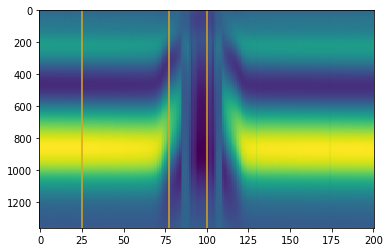

In [20]:
wl,raw, normal,meta = get_spects(dfp,mfp,bfp)
wl_range = wl[(wl>=400) & (wl<= 850)]
#Dictionary Generation
maps = normal[[(wl>=400) & (wl<= 850)][0],:]
plt.imshow(maps,aspect='auto')
for i in [25,77,100]:
    plt.axvline(i,c='goldenrod')
plt.show()
plt.close()
for i in [25,75,100]:
    plt.plot(wl_range,maps[:,i])
plt.show()